# Time Series Data - Electricity Load (ie Usage)

This dataset is from https://www.kaggle.com/robikscube/hourly-energy-consumption:

> PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.
> 
> The hourly power consumption data comes from PJM's website and are in megawatts (MW).
> 
> The regions have changed over the years so data may only appear for certain dates per region.

Forecasting time series data is different to other forms of machine learning problems due a few main reasons:
1. Time series data often is correlated with the past - e.g. today's value is influenced by last week's value. This is known as 'autocorrelation' (ie correlating with 'self')
2. Because time series has autocorrelation, the usual ML models that consider every data point 'independent' don't work well. However, with feature engineering, you can basically include the past values as columns or features.

This notebook will attempt to forecast energy consumption to give a bit of flavour of how time series forecasting works, comparing:
1. Holtwinters Triple Exponential Smoothing
2. Facebook's Prophet (also a Generalized Additive/Linear Model)
3. XGBoost Regressor (Ensemble Learning using Decision Trees with boosting)

# Housekeeping 

First we load the relevant libraries and configs

In [1]:
import pandas as pd
from datetime import datetime

# Configure matplotlib plotting
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = 11, 9 #Changes default matplotlib plots to this size

# Exploratory Data Analysis

We need to first check a few things:
1. Duplicate and missing data, as well as spread
2. How autocorrelated is this data and its seasonal decomposition

In [2]:
# Load my EDA helper function created to do some high-level analysis
class EDA():

    df = pd.DataFrame()
    
    def __init__(self, df):
        '''
        Creates EDA object for the DataFrame
        
        Note for time series data, have the index be the timestamp prior to creating this Object.
        
        :param df : DataFrame
        '''
        self.df = df
        
    def missing_values(self):
        '''
        Checks missing values
        
        :return DataFrame
        
        '''
        missing = self.df[self.df.isna().any(axis=1)]
        
        print("Missing values data")
        
        return missing
    
    def duplicate_values(self):
        duplicates = self.df[self.df.duplicated(subset=None, keep='first')==True]
        
        print("Duplicate values data")
        
        return duplicates
        
    def duplicate_indices(self):
        '''
        Check whether the indices have any duplicates
        
        :return DataFrame
        '''        
        duplicate_indices = self.df[self.df.index.duplicated()==True]
        
        return duplicate_indices
            
    def summary(self):
        '''
        Return summary/describe of DataFrame
        
        :return DataFrame
        '''
        df = self.df.reset_index() # Reset to include the index
        
        summary = df.describe(include='all').transpose()
        
        print("Summary metrics")
        
        return summary
    
    def pandas_profiling(self):
        import pandas_profiling
        
        self.df.profile_report(style={'full_width':True})  
    
    def histogram_KDE(self):
        ''' 
        :return seaborn plot
        '''       
        sns.pairplot(self.df, diag='kde')
        sns.distplot(kde=True, fit=[st.norm or st.lognorm])
        
    def outliers(self, col):
        ''' 
        Checks outliers - anything outside of 5% to 95% quartile range
        
        :param col : str
            Name of col to be tested
            
        :return DataFrame
        '''
        outliers = self.df[~self.df[col].between(self.df[col].quantile(.05), self.df[col].quantile(.95))]
        
        print("Outliers")
        
        return outliers
        
    def missing_timeseries_points(self, freq='D'):
        '''
        Checks whether there's any missing data points in continuous time series data.
        
        :param freq optional default = 'D' : str
            Frequency compliant with pandas formatting
        
        :return DataFrame
        '''
        # First create date range
        date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq=freq)

        # Now compare against dataset
        missing_timeseries = self.df.index[~self.df.index.isin(date_range)]
        
        print("Missing timeseries data")
        
        return missing_timeseries

    def corr_heatmap(df):
        fig, ax = plt.subplots(figsize=(10, 6))
        corr = self.df.corr()
        hm = sns.heatmap(round(corr,2), annot=True, cmap="coolwarm",fmt='.2f', linewidths=.05)
        fig.subplots_adjust(top=0.93)
        title = fig.suptitle('Wine Attributes Correlation Heatmap', fontsize=14)

        plt.show()

    def plot_time_series_seasonal_decomp(self, type='add'):
        '''
        Plots seasonal decomposition of timeseries data
        
        :return matplotlib Plot
        '''
        from statsmodels.tsa.seasonal import seasonal_decompose
        decomposition = seasonal_decompose(self.df, model='multiplicative')

        fig = decomposition.plot()
        plt.show()
   
    def time_series_ADF(self):            
        '''
        Returns Augmented Dickey-Fuller Test
        '''
        from statsmodels.tsa.stattools import adfuller as ADF

        series = data['KwH'] # ADF takes series, not DF

        result = ADF(series)

        print('ADF Statistic: %f4.2' % result[0])
        print('P-value %f4.2' % result[1])

In [3]:
# Load the Data
data = pd.read_csv("../input/hourly-energy-consumption/PJME_hourly.csv")

data.set_index('Datetime',inplace=True)

data.index = pd.to_datetime(data.index)

data_copy = data.copy(deep=True) # Make a deep copy, including a copy of the data and the indices
data.head(10)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
2002-12-31 06:00:00,26222.0
2002-12-31 07:00:00,28702.0
2002-12-31 08:00:00,30698.0
2002-12-31 09:00:00,31800.0


In [4]:
eda_helper = EDA(data)

eda_helper.summary()

Summary metrics


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Datetime,145366,145362,2014-11-02 02:00:00,2,2002-01-01 01:00:00,2018-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PJME_MW,145366,NaN,NaT,NaN,NaT,NaT,32080.2,6464.01,14544,27573,31421,35650,62009


In [5]:
eda_helper.missing_values()

Missing values data


,PJME_MW
Datetime,


In [6]:
eda_helper.duplicate_values()

Duplicate values data


,PJME_MW
Datetime,
2002-12-28 03:00:00,27526.0
2002-12-25 23:00:00,30698.0
2002-12-23 12:00:00,33144.0
2002-12-22 03:00:00,24907.0
2002-12-20 05:00:00,24363.0
...,...
2018-01-01 18:00:00,44147.0
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0


In [7]:
eda_helper.duplicate_indices()

,PJME_MW
Datetime,
2014-11-02 02:00:00,23755.0
2015-11-01 02:00:00,21171.0
2016-11-06 02:00:00,21692.0
2017-11-05 02:00:00,20666.0


In [8]:
def preprocess_data(df):
    # We have duplicates, so we need to de-duplicate it - grabbing first value that pops up for a time series
    df.sort_index()
    df = df.groupby(df.index).first()
    
    #Set freq to H
    df = df.asfreq('H')
    
    return df

In [9]:
data = preprocess_data(data)

data.index

DatetimeIndex(['2002-01-01 01:00:00', '2002-01-01 02:00:00',
               '2002-01-01 03:00:00', '2002-01-01 04:00:00',
               '2002-01-01 05:00:00', '2002-01-01 06:00:00',
               '2002-01-01 07:00:00', '2002-01-01 08:00:00',
               '2002-01-01 09:00:00', '2002-01-01 10:00:00',
               ...
               '2018-08-02 15:00:00', '2018-08-02 16:00:00',
               '2018-08-02 17:00:00', '2018-08-02 18:00:00',
               '2018-08-02 19:00:00', '2018-08-02 20:00:00',
               '2018-08-02 21:00:00', '2018-08-02 22:00:00',
               '2018-08-02 23:00:00', '2018-08-03 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145392, freq='H')

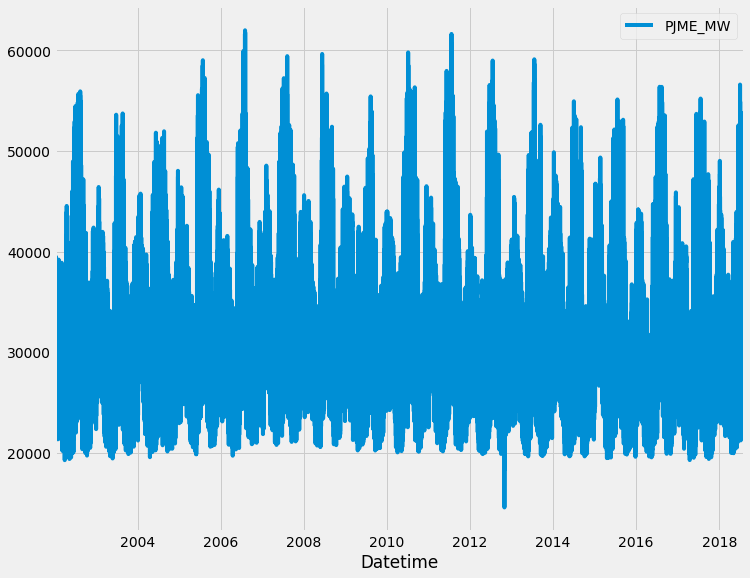

In [10]:
# Let's visualise the data
data.plot()

plt.show()

You can see because the frequency is at the hourly level, this is will make forecasting difficult (and its also difficult to visualise too!)

So what we will do is resample it and aggregate it to the daily level

In [11]:
# Given there's no missing data, we can resample the data to daily level
daily_data = data.resample(rule='D').sum()

# Set frequency explicitly to D
daily_data = daily_data.asfreq('D')

daily_data.head(10)

,PJME_MW
Datetime,
2002-01-01,714857.0
2002-01-02,822277.0
2002-01-03,828285.0
2002-01-04,809171.0
2002-01-05,729723.0
2002-01-06,727766.0
2002-01-07,800012.0
2002-01-08,824710.0
2002-01-09,810628.0


In [12]:
# We can confirm it is at the right frequency
daily_data.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-28',
               '2018-07-29', '2018-07-30', '2018-07-31', '2018-08-01',
               '2018-08-02', '2018-08-03'],
              dtype='datetime64[ns]', name='Datetime', length=6059, freq='D')

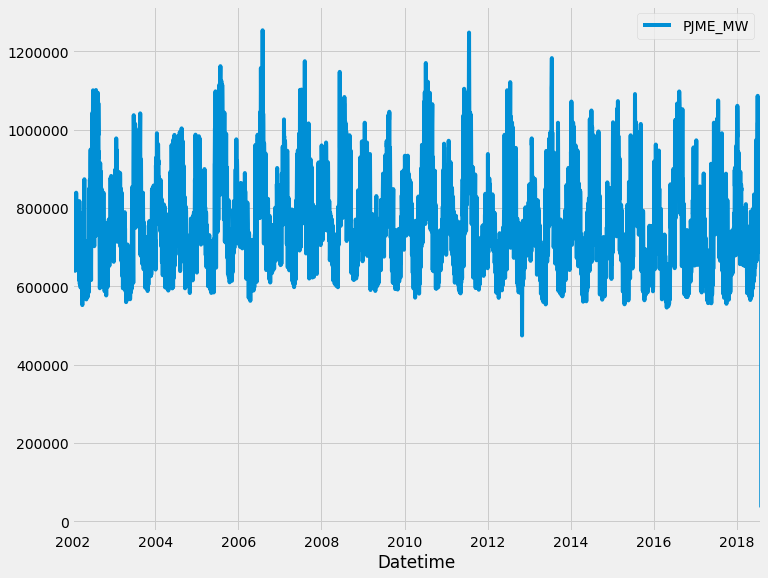

In [13]:
# Let's visualise the data again
daily_data.plot()

plt.show()

Now there's a tail end where it's not a full day, so it's dropping off.

For our purposes, we will just delete that part day.

In [14]:
daily_data = daily_data.drop([daily_data.index.min(), daily_data.index.max()])

Good, so there's no missing or duplicate data and you can see the data is from 1 Jan 2002 to 2 August 2018.

**Seasonal Decomposition**

Time series data can be thought of as components put together. That is:

***Time Series Data (at a particular point) = Level + Trend + Seasonality + Noise (ie Residual)***

* Level: the average value in the series.
* Trend: the increasing or decreasing value in the series.
* Seasonality: the repeating short-term cycle in the series.
* Noise: the random variation in the series.

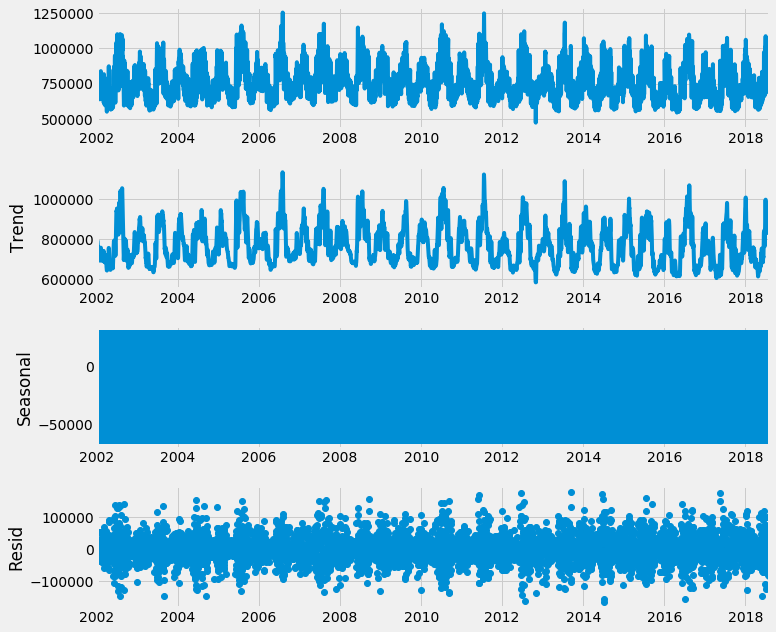

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(daily_data, model='additive')

fig = decomposition.plot()
plt.show()

There's too much noise!

How about we aggregate up to weekly level to reduce the noise

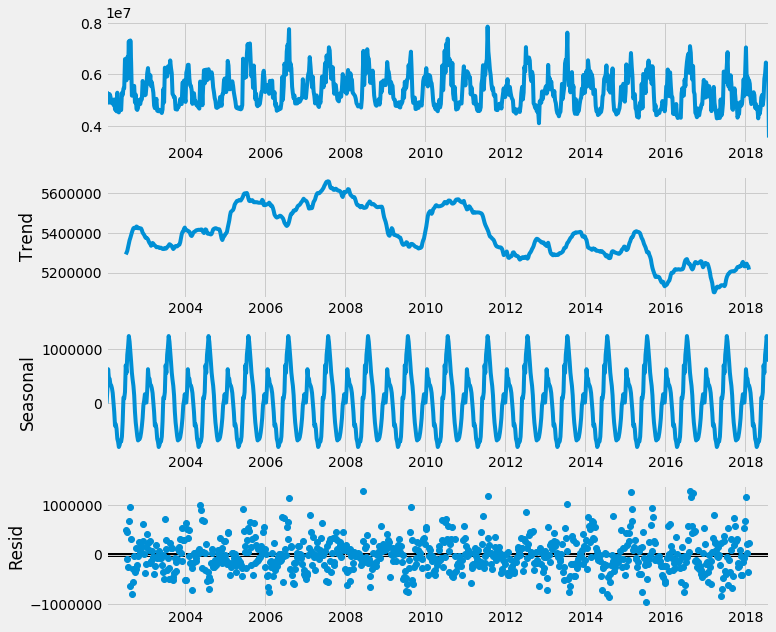

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
weekly_data = data.resample(rule='W').sum()
decomposition = seasonal_decompose(weekly_data, model='additive') # Aggregate to weekly level

fig = decomposition.plot()
plt.show()

Let's have a look at whether the data is 'stationary' or not - ie whether the data is affected by factors other than the passsage of time.

'Stationary' means only the passage of time affects it. Non-stationary means the trends, seasonality changes over time.

Closer P-Value is to 1, the more likely the dataset is affected by non-time factors.

That is, there is a X% that my dataset is not 'stationary'.

If it is below 5%, generally it cannot be considered non-stationary.

In [17]:
from statsmodels.tsa.stattools import adfuller as ADF

series = daily_data['PJME_MW'] # ADF takes series, not DF

result = ADF(series)

print('ADF Statistic: %f4.2' % result[0])
print('P-value %f4.2' % result[1])

ADF Statistic: -8.2365364.2
P-value 0.0000004.2


You can see both the seasonal decomposition and ADF show this data has a lot of noise and crazy swings!!

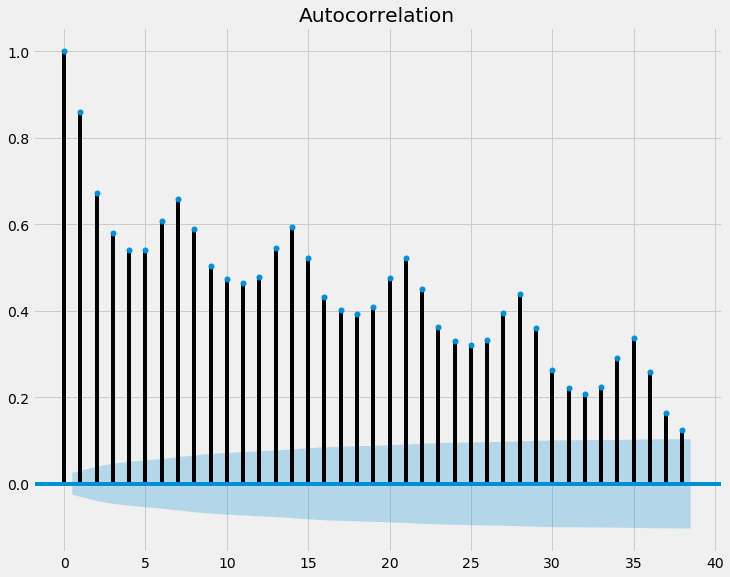

In [18]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

# Plot the acf function
plot_acf(daily_data) #alpha 1 suppress CI

plt.show()

Basically what this graph shows is any points above the blue shaded area (the confidence interval) is considered statistically significant.

This shows that yesterday's value has a very high correlation with today's value and there is seasonality - every 6 months it seems to repeat itself.

My personal guess is because of weather - winter and summer have higher electricity usage.

# Train Test Split 
Before we continue, let us split the data up between train and split with a specified cutoff date.

Let's pick 3 August 2017 (12 months prior)

In [19]:
# First we split it up between train and test
# We will aim for a 12 month forecast horizon (ie predict the last 12 months in the dataset)
cutoff = '2017-08-03'

daily_data.sort_index()

train = daily_data[:cutoff]
test = daily_data[cutoff:]

# 1. Holtwinters Triple Exponential Smoothing
Next we will use a time series forecasting model that takes advantage of the above identified components.

This is known as a 'generative additive model', as the final forecast value is 'adding' together multiple components.

The 'Triple' refers to the three components:
1. Level
2. Trend
3. Seasonality

Holtwinters works really well when the data is seasonal and has trends.

'Smoothing' basically means more weight is put on more recent data compared to the past.

Note the main hyperparameters for the model are:
* **Additive vs Multiplicative **(ie 'add' or 'mul') 
* **Box Cox** - to use box cox log transformation to reduce the 'noise' of the data
* **Alpha** - smoothing factor between 0 and 1. 1 means will always take yesterday's value (naive forecasting). 0 means take simple average of past.

Additive means the formula looks more like this: Data = Level + Trend + Seasonality

Multiplicative means the formula looks more like this: Data = Level x Trend x Seasonality

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# First we split it up between train and test
htrain = train['PJME_MW'] # HWES takes series, not DF
htest = test['PJME_MW'] # HWES takes series, not DF

model = ExponentialSmoothing(
    htrain
    ,trend='add'
    ,seasonal='add'
    ,freq='D'
    ,seasonal_periods=183 #Default is auto estimated - 4 is quarterly and 7 is weekly
).fit(
    optimized=True # Default is True - auto estimates the other parameters using Grid Search
    ,use_basinhopping=True # Uses Basin Hopping Algorithm for optimising parameters
    ,use_boxcox='log' #Boxcox transformation via log
    #,smoothing_level= # Alpha
    #,smoothing_slope= # Beta
    #,smoothing_seasonal= # Gamma
)

HWES_prediction = model.predict(start=htest.index[0], end=htest.index[-1])

print("Finished training and predicting")

# Let's see what the model did
model.summary()

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Finished training and predicting


Dep. Variable:,endog,No. Observations:,5693
Model:,ExponentialSmoothing,SSE,19971229922883.508
Optimized:,True,AIC,125496.583
Trend:,Additive,BIC,126739.570
Seasonal:,Additive,AICC,125509.634
Seasonal Periods:,183,Date:,"Mon, 23 Mar 2020"
Box-Cox:,True,Time:,07:30:30
Box-Cox Coeff.:,log,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_slope,1.0361e-08,beta,True


In [21]:
# Evaluate it's performance using Mean Absolute Error (MAE)
from statsmodels.tools.eval_measures import meanabs

print("MAE HWES ADD : %f4.2" % meanabs(htest, HWES_prediction))

MAE HWES ADD : 83307.8173444.2


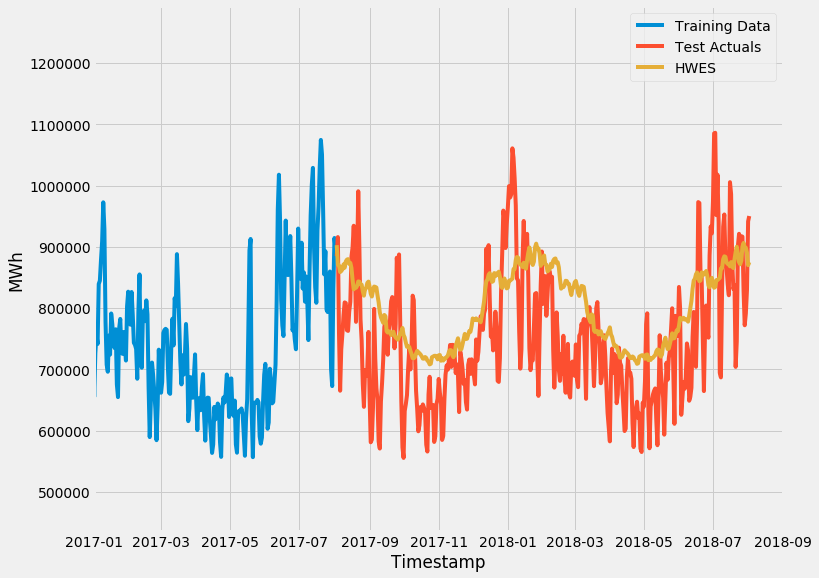

In [22]:
# Let's visually see the results
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Actuals')
plt.plot(HWES_prediction, label='HWES')

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

# For clarify, let's limit to only 2017 onwards
plt.xlim(datetime(2017, 1, 1),datetime(2018, 9, 1))

plt.show()

That's horrible! Let's try it again, but at the weekly level

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


Finished training and predicting


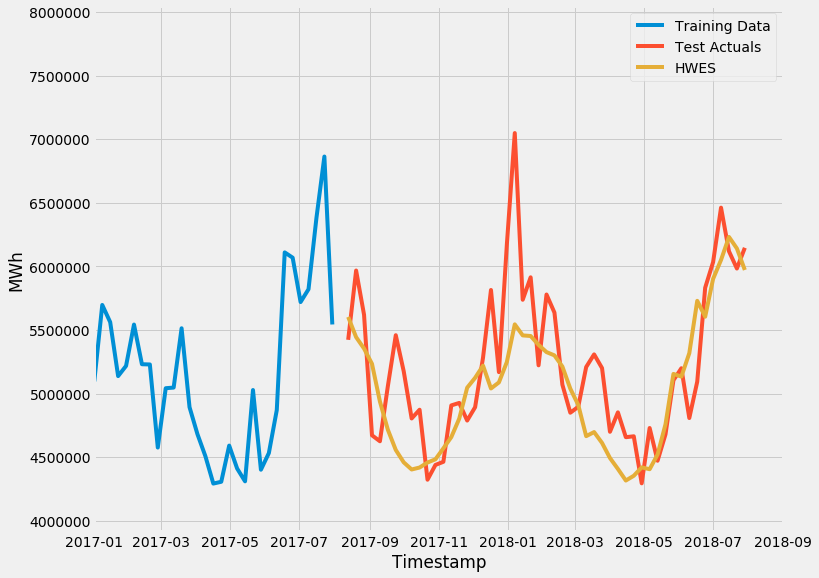

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# First we split it up between train and test
weekly_train = train.resample(rule='W').sum()
weekly_test = test.resample(rule='W').sum()

# Remove partial days (first and last weeks)
weekly_train = weekly_train.drop([weekly_train.index.min(), weekly_train.index.max()])
weekly_test = weekly_test.drop([weekly_test.index.min(), weekly_test.index.max()])

# HWES takes series, not DF
htrain = weekly_train['PJME_MW']
htest = weekly_test['PJME_MW']

model = ExponentialSmoothing(
    htrain
    ,trend='add'
    ,seasonal='add'
).fit(
    use_boxcox='log'
)

HWES_prediction_weekly = model.predict(start=htest.index[0],end=htest.index[-1]) # Need to get the nearest start of week

print("Finished training and predicting")

# Let's visually see the results
plt.plot(weekly_train, label='Training Data')
plt.plot(weekly_test, label='Test Actuals')
plt.plot(HWES_prediction_weekly, label='HWES')

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

# For clarify, let's limit to only 2017 onwards
plt.xlim(datetime(2017, 1, 1),datetime(2018, 9, 1))

plt.show()

In [24]:
# Evaluate it's performance using Mean Absolute Error (MAE)
from statsmodels.tools.eval_measures import meanabs

print("MAE HWES ADD : %f4.2" % meanabs(htest, HWES_prediction_weekly))

MAE HWES ADD : 338986.4092724.2


It seems more accurate, but it is because its aggregated to weekly level.

So it seems Exponential Smoothing is a no-go - let's see how the others fare.

# XGBoost - Ensemble Learning

XGBoost has gained in popularity recently - it is essentially uses a group of decision trees to get the result.

However, each new tree is a fit on a modified version of the original dataset and learns the 'mistakes' of the prior tree (ie boosting).

The result is the group of trees will have weightings - the better performing ones get more weight. The final result is a weighted vote.

If you want more details, the documentation is here: https://xgboost.readthedocs.io/en/latest/tutorials/model.html.

However, the main takeaways are:
* Many trees are created from the dataset
* Each tree learns from the 'mistakes' of the prior ones
* The end result basically is weighted between 'weak' and 'strong' trees

**Feature Engineering**

As eluded earlier, most machine learning models (with exception of many Recurrent Neural Networks), don't 'look back' to prior values.

Essentially if you have a table, each 'row' is an independent data point and the ML model doesn't consider the prior row's data.

This is problematic for time series data, as you can see autocorrelation is very obvious.

In [25]:
# Feature Engineering first

def preprocess_xgb_data(df):
    '''
    Takes data and preprocesses for XGBoost.
    
    Returns tuple : (data, target)
    '''
    # Let's add in lag of 365 days of data - ie make the model consider 365 days of prior data
    for i in range(1,365):
        df[f'PJME_MW {i}'] = df.shift(periods=i, freq='D')['PJME_MW']

    df.reset_index(inplace=True)

    # Split out attributes of timestamp - hopefully this lets the algorithm consider seasonality
    df['date_epoch'] = pd.to_numeric(df['Datetime'])
    df['dayofweek'] = df['Datetime'].dt.dayofweek
    df['quarter'] = df['Datetime'].dt.quarter
    df['month'] = df['Datetime'].dt.month
    df['year'] = df['Datetime'].dt.year
    df['dayofyear'] = df['Datetime'].dt.dayofyear
    df['dayofmonth'] = df['Datetime'].dt.day
    df['weekofyear'] = df['Datetime'].dt.weekofyear
    
    x = df.drop(columns=['Datetime', 'PJME_MW']) #Don't need timestamp and target
    y = df['PJME_MW'] # Target prediction is the load
    
    return x, y

Now we need to split the time series between training and test - like what we did before.

Cross validation is harder in this case, as the datasets need to be sequential.

We will also need to specify features and labels (ie the target we want to predict).

In [26]:
xtrain = train.copy() #Otherwise it becomes a pointer
xtest = test.copy() # Otherwise it becomes a pointer

train_feature, train_label = preprocess_xgb_data(xtrain)
test_feature, test_label = preprocess_xgb_data(xtest)

In [27]:
#Train and predict using XGBoost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split

# We will try with 1000 trees and a maximum depth of each tree to be 5
# Early stop if the model hasn't improved in 100 rounds
model = XGBRegressor(
    max_depth=6 # Default - 6
    ,n_estimators=1000
    ,booster='gbtree'
    ,colsample_bytree=1 # Subsample ratio of columns when constructing each tree - default 1
    ,eta=0.3 # Learning Rate - default 0.3
    ,importance_type='weight' # Default is gain
)
model.fit(
    train_feature
    ,train_label
    ,eval_set=[(train_feature, train_label)]
    ,eval_metric='mae'
    ,verbose=True
    ,early_stopping_rounds=100 # Stop after 100 rounds if it doesn't after 100 times
)

xtest['PJME_MW Prediction'] = model.predict(test_feature)
XGB_prediction = xtest[['Datetime', 'PJME_MW Prediction']].set_index('Datetime')

[0]	validation_0-mae:540217.56250
Will train until validation_0-mae hasn't improved in 100 rounds.
[1]	validation_0-mae:378504.53125
[2]	validation_0-mae:265275.50000
[3]	validation_0-mae:186087.10938
[4]	validation_0-mae:130585.53125
[5]	validation_0-mae:91838.75000
[6]	validation_0-mae:65255.77344
[7]	validation_0-mae:47757.48047
[8]	validation_0-mae:37164.70703
[9]	validation_0-mae:30956.99219
[10]	validation_0-mae:27449.91602
[11]	validation_0-mae:25289.77539
[12]	validation_0-mae:24002.64844
[13]	validation_0-mae:23285.23633
[14]	validation_0-mae:22845.90820
[15]	validation_0-mae:22605.05664
[16]	validation_0-mae:21883.01172
[17]	validation_0-mae:21692.77344
[18]	validation_0-mae:21565.25195
[19]	validation_0-mae:21457.90820
[20]	validation_0-mae:21193.70117
[21]	validation_0-mae:20872.79102
[22]	validation_0-mae:20474.40625
[23]	validation_0-mae:20314.55664
[24]	validation_0-mae:20037.25781
[25]	validation_0-mae:19893.08008
[26]	validation_0-mae:19532.26953
[27]	validation_0-mae:

Let's see how well it performed (in terms of MAE)

In [28]:
from sklearn.metrics import mean_absolute_error
print("MAE XGB: %f4.2" % mean_absolute_error(test_label, XGB_prediction['PJME_MW Prediction']))

MAE XGB: 43437.2208904.2


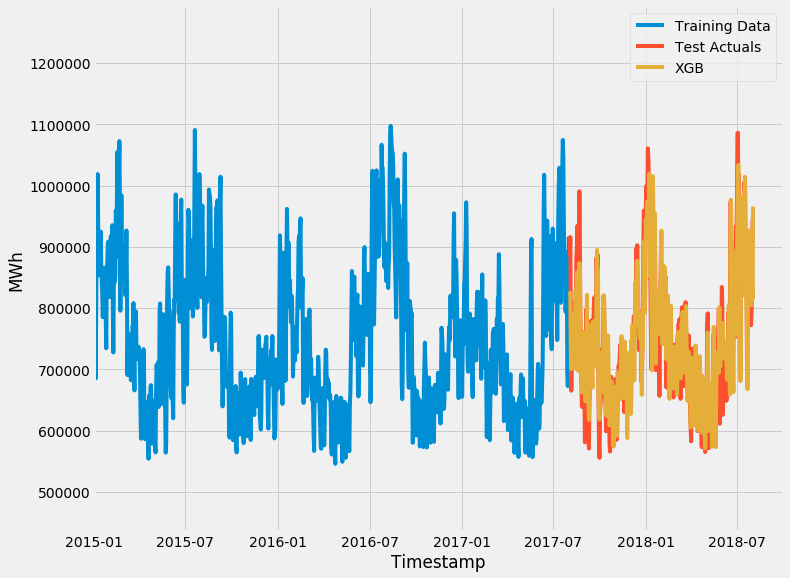

In [29]:
# Let's visually see the results
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Actuals')
plt.plot(XGB_prediction, label='XGB')

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

# For clarify, let's limit to only 2015 onwards
plt.xlim(datetime(2015, 1, 1),datetime(2018, 10, 1))

plt.show()

Let's see what the algorithm considered most important - we'll grab the **Top 10 features by weight**

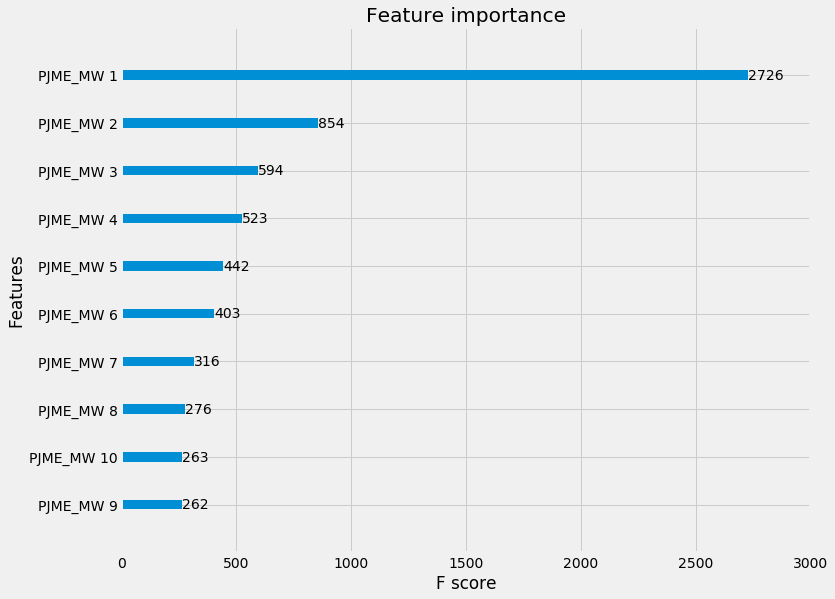

In [30]:
import xgboost as xgb

xgb.plot_importance(model, max_num_features=10, importance_type='weight') # "weight” is the number of times a feature appears in a tree

plt.show()

So it seems the prior day value has the highest weight - makes sense, given the autocorrelation graph showed yesterday's value was very highly correlated with today's value.

# 3. Prophet
Facebook Prophet is an open-source library that is similiar to Holtwinters, but essentially decomposes time series by:

Time series Data = Trend +/x Seasonality +/x Holidays +/x Noise

* Trend - models non-periodic changes; linear or logistic
* Seasonality - represents periodic changes i.e. weekly, monthly, yearly
* Holidays - irregular blips on potentially irregular schedules
* Noise - the random variation in the series

In [31]:
from fbprophet import Prophet

ftrain = train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW': 'y'}) # Prophet takes ds and y as column names only

model = Prophet(
    n_changepoints=25 # Default is 25
    ,changepoint_prior_scale=0.05 # Default is 0.05
    ,seasonality_mode='additive'
)
model.fit(ftrain)

# Create the future dataframe with date range that will be used to test accuracy
future_df = test.reset_index()['Datetime'].to_frame().rename(columns={"Datetime":'ds'})

# Predict the future
forecast = model.predict(future_df)

PROPHET_prediction = forecast.set_index('ds')['yhat'][cutoff:]

print("Finished training and predicting")

Finished training and predicting


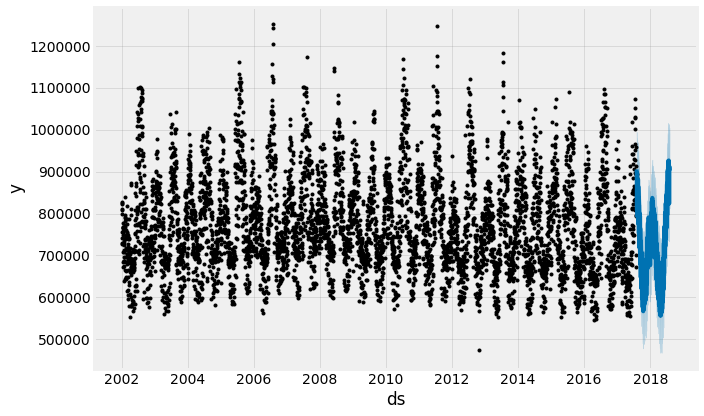

In [32]:
model.plot(forecast)

plt.show()

Like Holtwinters, let's see the decomponent of the model

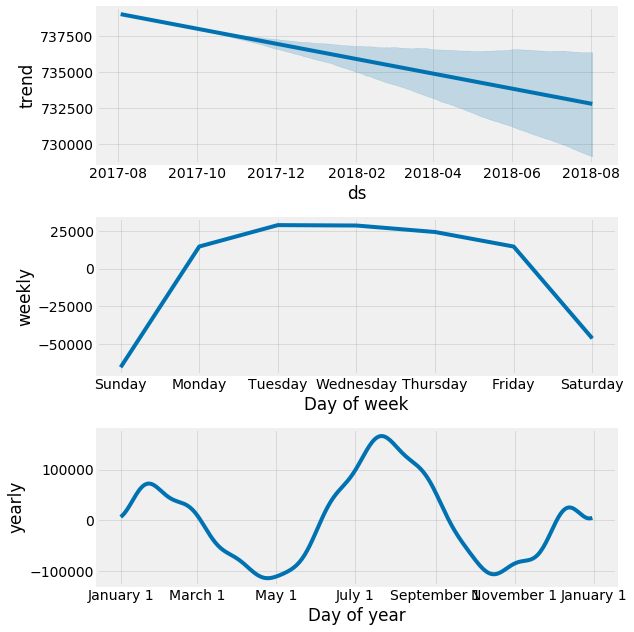

In [33]:
model.plot_components(forecast)

plt.show()

You can easily see seasonality and trends - there's a clear downward trend and seasonality every year (more electricity is used in winter)

# Bringing it all together - the final results

Let's bring the three models together and see which one did the best

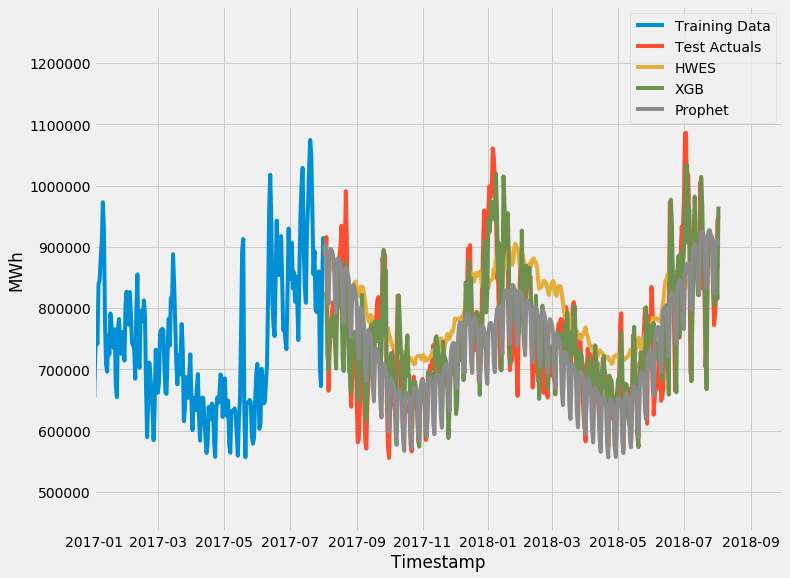

In [34]:
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Actuals')
plt.plot(HWES_prediction, label='HWES')
plt.plot(XGB_prediction, label='XGB')
plt.plot(PROPHET_prediction, label='Prophet')
# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

# For clarify, let's limit to only 2017 onwards
plt.xlim(datetime(2017, 1, 1),datetime(2018, 10, 1))

plt.show()

The final MAE results between the three models

In [35]:
print("MAE HWES ADD : %f4.2" % meanabs(test['PJME_MW'], HWES_prediction))
print("MAE XGB: %f4.2" % mean_absolute_error(test_label, XGB_prediction['PJME_MW Prediction']))
print("MAE Prophet : %f4.2" % meanabs(test['PJME_MW'], PROPHET_prediction))

MAE HWES ADD : 83307.8173444.2
MAE XGB: 43437.2208904.2
MAE Prophet : 61524.7308534.2


**So in conclusion, it seems XGBoost is the best performing for this dataset!**